In [ ]:
# to query the data set from Dropbox
! wget https://www.dropbox.com/s/k99m7nuoa6oprix/data_v1.0.csv

--2021-05-19 13:27:18--  https://www.dropbox.com/s/k99m7nuoa6oprix/data_v1.0.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k99m7nuoa6oprix/data_v1.0.csv [following]
--2021-05-19 13:27:18--  https://www.dropbox.com/s/raw/k99m7nuoa6oprix/data_v1.0.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdfa455cce0b3c3ed74ab5a9c2c.dl.dropboxusercontent.com/cd/0/inline/BOzO2hrFAMi9gbgkf2q0uNI14fEOn0hfsNl5YJgf2_mx1bbXqEPp5V0aUkEKDch1VkwsflcEAmu_wgmagzMQYM9zYc8VrHcZ0NNoSAnVXk9T7QhZyv_tH9LjDORiOCTTrPbpv5cAS3vTvL9DB-PLq43H/file# [following]
--2021-05-19 13:27:19--  https://ucdfa455cce0b3c3ed74ab5a9c2c.dl.dropboxusercontent.com/cd/0/inline/BOzO2hrFAMi9gbgkf2q0uNI14fEOn0hfsNl5YJgf2_mx1bbXqEPp5V0aUkEKDch1VkwsflcEAmu_wgmagzMQYM9

In [ ]:
# imports

import os
import pandas as pd
import numpy as np
import tempfile
import matplotlib as mpl

import seaborn as sns
from sklearn import tree
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot

import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.svm import SVR, SVC
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split, cross_val_score,RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# loading the dataset in Memory
features = ['date','cheveux','age','exp','salaire','sexe','diplome','specialite','note','dispo','embauche']
dataset = pd.read_csv('data_v1.0.csv', usecols= features, )


1. Exploring the Dataset 


In [ ]:
shape = dataset.shape 
types = dataset.dtypes 
description = dataset.describe()
class_counts = dataset.groupby('embauche').size()
correlations = dataset.corr(method='pearson')
skew = dataset.skew()

In [ ]:
dataset.head()

,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,2011-07-01,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0


In [ ]:
shape

(20000, 11)

In [ ]:
types

date           object
cheveux        object
age           float64
exp           float64
salaire       float64
sexe           object
diplome        object
specialite     object
note          float64
dispo          object
embauche        int64
dtype: object

In [ ]:
description

,age,exp,salaire,note,embauche
count,19909.000000,19904.000000,19905.000000,19886.000000,20000.000000
mean,35.004521,9.500352,34974.343934,75.168762,0.114600
std,9.609169,3.012109,5003.099616,17.095926,0.318547
min,-3.000000,-2.000000,14128.000000,8.680000,0.000000
25%,29.000000,7.000000,31596.000000,63.720000,0.000000
50%,35.000000,9.000000,34979.000000,75.080000,0.000000
75%,41.000000,12.000000,38358.000000,86.617500,0.000000
max,74.000000,23.000000,53977.000000,143.220000,1.000000


In [ ]:
class_counts #unbalanced targets

embauche
0    17708
1     2292
dtype: int64

In [ ]:
correlations

,age,exp,salaire,note,embauche
age,1.000000,-0.002786,0.001161,-0.007534,-0.011623
exp,-0.002786,1.000000,0.009709,-0.012195,0.006604
salaire,0.001161,0.009709,1.000000,-0.448422,0.002342
note,-0.007534,-0.012195,-0.448422,1.000000,0.003019
embauche,-0.011623,0.006604,0.002342,0.003019,1.000000


In [ ]:
skew

age         0.011699
exp         0.006383
salaire    -0.005519
note       -0.009946
embauche    2.419982
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0fec2a8d0>,
      dtype=object)

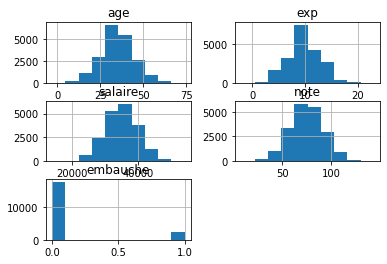

In [ ]:
dataset.hist() 

2. Data preparation/cleaning 

In [ ]:
# fix quantitative variables
dataset['age'] = dataset['age'].apply(lambda x: np.nan if x<0 else x )
dataset['exp'] = dataset['exp'].apply(lambda x: np.nan if x<0 else x )

# drop date feature (No need to use it)
dataset.pop('date')

# fix missing data using imputation with most_frequent strategy
imp = SimpleImputer(strategy="most_frequent")
data_imputed = imp.fit_transform(dataset)
data_imputed = pd.DataFrame(data_imputed, columns=['cheveux', 'age', 'exp', 'salaire',
                                                   'sexe', 'diplome', 'specialite', 'note',
                                                   'dispo', 'embauche'])

# Enocoding categorical variables
le = LabelEncoder()
data_imputed['dispo'] = le.fit_transform(data_imputed['dispo'].astype(str))
data_imputed['cheveux'] = le.fit_transform(data_imputed['cheveux'].astype(str))
data_imputed['sexe'] = le.fit_transform(data_imputed['sexe'].astype(str))
data_imputed['specialite'] = le.fit_transform(data_imputed['specialite'].astype(str))
data_imputed['diplome'] = le.fit_transform(data_imputed['diplome'].astype(str))

# sclaing continuous variables
scaler = StandardScaler()
data_imputed[['exp', 'age', 'salaire', 'note']] = scaler.fit_transform(data_imputed[['exp', 'age', 'salaire', 'note']])



**3. Correlation analysis**

In [ ]:
# calculate dependency/correlation between categorical variables 
table = pd.crosstab(data_imputed['specialite'], data_imputed['sexe'])
resultats_test = chi2_contingency(table)
print("statistique de test :", resultats_test[0])
print("p-value :", resultats_test[1])
print("degré de liberté :", resultats_test[2])

statistique de test : 2687.449690280542
p-value : 0.0
degré de liberté : 3


In [ ]:
# calculate dependency/correlation between continuous variables

pd.DataFrame(pearsonr(data_imputed['note'], data_imputed['exp']),
             index = ['pearson_coeff', 'p-value'],
             columns = ['resultat_test'])

,resultat_test
pearson_coeff,-0.012390
p-value,0.079748


In [ ]:
# calculate dependency/correlation between continuous and categorical variables (ANOVA)
anova_df = data_imputed[['cheveux','salaire']]
anova = smf.ols(formula='salaire ~ C(cheveux)', data=anova_df).fit()
aov_table = sm.stats.anova_lm(anova, typ=2)
print(anova.summary())
aov_table

                            OLS Regression Results                            
Dep. Variable:                salaire   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     29.26
Date:                Thu, 06 May 2021   Prob (F-statistic):           7.20e-19
Time:                        13:47:05   Log-Likelihood:                -28335.
No. Observations:               20000   AIC:                         5.668e+04
Df Residuals:                   19996   BIC:                         5.671e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0609      0.013     

,sum_sq,df,F,PR(>F)
C(cheveux),87.416434,3.0,29.260878,7.203382e-19
Residual,19912.583566,19996.0,NaN,NaN


**3. Machine Learning Models**

In [ ]:
 # train test split

features = ['cheveux', 'age', 'exp', 'salaire', 'sexe', 'diplome', 'specialite', 'note', 'dispo']
X_train, X_test, y_train, y_test = train_test_split(data_imputed[features], data_imputed['embauche'], test_size=0.33, random_state=42)

# Feature ranking with recursive feature elimination.
estimator = SVR(kernel="rbf")
selector = RFE(estimator, n_features_to_select=9, step=1)
selector = selector.fit(X_train, y_train)
print(selector.support_)
print(selector.ranking_)

[ True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1]


In [ ]:
# SVC Model to Handel Unbalanced classes

# svc classifier with gaussian Kernel 
svm_clf = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel = 'rbf',
                                              class_weight='balanced')) # penalize unbalnced classes
svm_clf.fit(np.array(X_train), np.array(y_train.astype('int')))
y_pred = svm_clf.predict(X_test)

# Model evaluation 
cm = confusion_matrix(y_test.astype('int'), y_pred)
precision_recall_fscore_support(y_test.astype('int'), y_pred, average='macro')
classification_report = classification_report(y_test.astype('int'), y_pred, target_names=['class 0', 'class 1'])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(svm_clf, np.array(X_train), np.array(y_train.astype('int')), scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('precision_recall_fscore_support: ', precision_recall_fscore_support)
print('Mean ROC AUC: %.3f' % np.mean(scores))
print("confusion_matrix: ", cm)
print("classification_report: ", classification_report)

precision_recall_fscore_support:  <function precision_recall_fscore_support at 0x7fa144e900e0>
Mean ROC AUC: 0.872
confusion_matrix:  [[4741 1094]
 [ 169  596]]
classification_report:                precision    recall  f1-score   support

     class 0       0.97      0.81      0.88      5835
     class 1       0.35      0.78      0.49       765

    accuracy                           0.81      6600
   macro avg       0.66      0.80      0.68      6600
weighted avg       0.89      0.81      0.84      6600



Mean ROC AUC: 0.872
[[5776   59]
 [ 487  278]]
              precision    recall  f1-score   support

     class 0       0.97      0.81      0.88      5835
     class 1       0.35      0.78      0.49       765

    accuracy                           0.81      6600
   macro avg       0.66      0.80      0.68      6600
weighted avg       0.89      0.81      0.84      6600

Feature: 0, Score: 0.08447
Feature: 1, Score: 0.11322
Feature: 2, Score: 0.08392
Feature: 3, Score: 0.19681
Feature: 4, Score: 0.03581
Feature: 5, Score: 0.06853
Feature: 6, Score: 0.08233
Feature: 7, Score: 0.28836
Feature: 8, Score: 0.04655


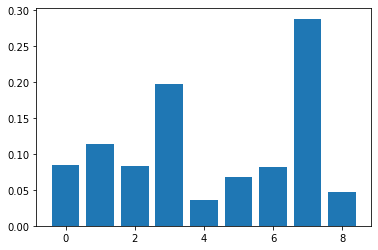

In [ ]:
# Random Forest Classifier 
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced') # penalize unbalnced classes 
clf =clf.fit(np.array(X_train), np.array(y_train.astype('int')))
y_pred = clf.predict(X_test)

# model evaluation 
cm = confusion_matrix(y_test.astype('int'), y_pred)
precision_recall_fscore_support(y_test.astype('int'), y_pred, average='macro')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(clf, np.array(X_train), np.array(y_train.astype('int')), scoring='roc_auc', cv=cv, n_jobs=-1)

# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))
print(cm)
print(classification_report)

# summarize feature importance
importance = clf.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

**4.Deep Neural Network For Binary Classification on unbalanced data**

In [ ]:
dataset.head()

,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0


In [ ]:
# working  on fresh data set 
Neural_Network_data_set = data_imputed.copy()
Neural_Network_data_set.pop("cheveux")
Neural_Network_data_set.pop("sexe")
Neural_Network_data_set.pop("dispo")

0        0
1        0
2        0
3        0
4        0
        ..
19995    0
19996    0
19997    1
19998    0
19999    0
Name: dispo, Length: 20000, dtype: int64

In [ ]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(Neural_Network_data_set, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('embauche'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('embauche'))
test_labels = np.array(test_df.pop('embauche'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [ ]:
# check shapes 
print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (12800,)
Validation labels shape: (3200,)
Test labels shape: (4000,)
Training features shape: (12800, 6)
Validation features shape: (3200, 6)
Test features shape: (4000, 6)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


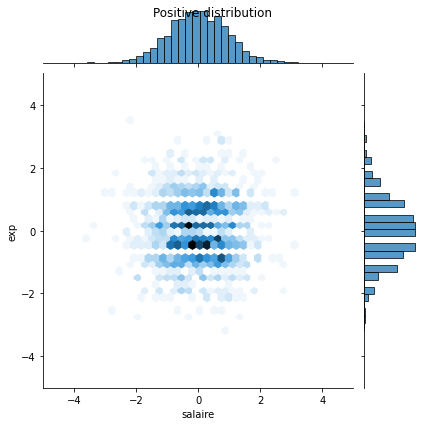

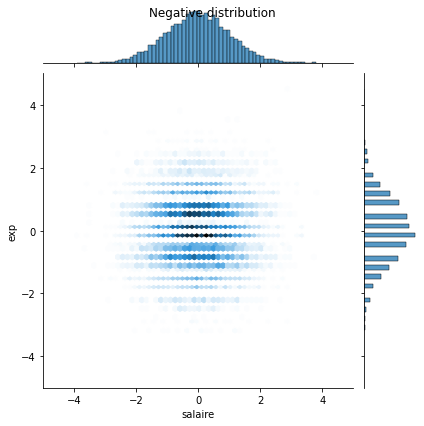

In [ ]:
# compare the distributions of positive and negative examples on some features (exp & salaire)

pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['salaire'], pos_df['exp'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['salaire'], neg_df['exp'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [ ]:
# Neural Network Architecture 

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
EPOCHS = 50
BATCH_SIZE = 4

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(6,)),
      tf.keras.layers.Dense(32, activation=tf.nn.relu),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(16, activation=tf.nn.relu),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  return model

In [ ]:
# check model params 
model = make_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 6)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                224       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# check loss
results = model.evaluate(np.array(train_features.astype('float32')), np.array(train_labels.astype('float32')), batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.3307


In [ ]:
# define Initial bias error
neg, pos = np.bincount(dataset['embauche'])
total = neg + pos
initial_bias = np.log([pos/neg])
initial_bias

# check model after introducing Initial bias
model = make_model(output_bias=initial_bias)
results = model.evaluate(np.array(train_features.astype('float32')), np.array(train_labels.astype('float32')), batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3751


In [ ]:
# Save Initial weights To make the different training executions more comparable
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
# Confirm that correcting the bias helps

# first model 
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features.astype('float32'),
    train_labels.astype('float32'),
    batch_size=4,
    epochs=20,
    validation_data=(np.array(val_features.astype('float32')), np.array(val_labels.astype('float32'))), 
    verbose=0)

# second model 
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features.astype('float32'),
    train_labels.astype('float32'),
    batch_size=4,
    epochs=20,
    validation_data=(np.array(val_features.astype('float32')), np.array(val_labels.astype('float32'))), 
    verbose=0)

# prepare for plotting comparisaon 
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

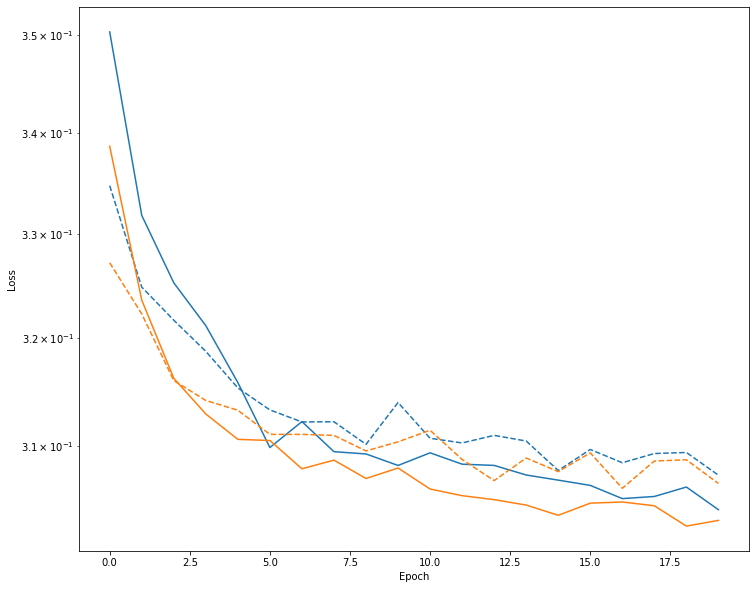

In [ ]:
# Plotting comparisaon
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [ ]:
# Train the Neural Network 
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features.astype('float32'),
    train_labels.astype('float32'),
    batch_size=2,
    epochs=30,
    callbacks=[early_stopping],
    validation_data=(np.array(val_features.astype('float32')), np.array(val_labels.astype('float32'))))

Epoch 1/30
6400/6400 [==============================] - 16s 2ms/step - loss: 0.3387 - tp: 63.6580 - fp: 34.7532 - tn: 8484.5582 - fn: 1019.0303 - accuracy: 0.8904 - precision: 0.6458 - recall: 0.0675 - auc: 0.6786 - prc: 0.2713 - val_loss: 0.3271 - val_tp: 23.0000 - val_fp: 5.0000 - val_tn: 2818.0000 - val_fn: 354.0000 - val_accuracy: 0.8878 - val_precision: 0.8214 - val_recall: 0.0610 - val_auc: 0.7172 - val_prc: 0.3094
Epoch 2/30
6400/6400 [==============================] - 13s 2ms/step - loss: 0.3182 - tp: 49.7104 - fp: 23.1484 - tn: 5644.9705 - fn: 684.1704 - accuracy: 0.8920 - precision: 0.6898 - recall: 0.0716 - auc: 0.7018 - prc: 0.2910 - val_loss: 0.3211 - val_tp: 27.0000 - val_fp: 10.0000 - val_tn: 2813.0000 - val_fn: 350.0000 - val_accuracy: 0.8875 - val_precision: 0.7297 - val_recall: 0.0716 - val_auc: 0.7306 - val_prc: 0.3317
Epoch 3/30
6400/6400 [==============================] - 13s 2ms/step - loss: 0.3279 - tp: 66.1697 - fp: 27.9777 - tn: 5614.2486 - fn: 693.6038 - accur

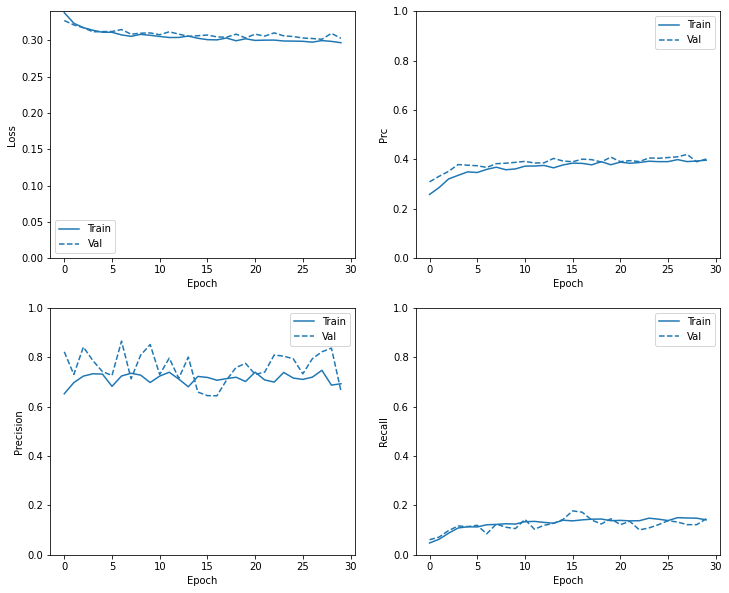

In [ ]:
# Plotting the Metrics
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
plot_metrics(baseline_history)

In [ ]:
# prepare predictions 
train_predictions_baseline = model.predict(np.array(train_features.astype('float32')), batch_size=2)
test_predictions_baseline = model.predict(np.array(test_features.astype('float32')), batch_size=2)

In [ ]:
# prepare plots 
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('not hired Detected (True Negatives): ', cm[0][0])
  print('hired Incorrectly Detected (False Positives): ', cm[0][1])
  print('not hired Missed (False Negatives): ', cm[1][0])
  print('hired Detected (True Positives): ', cm[1][1])
  print('Total : ', np.sum(cm[1]))

loss :  0.29717883467674255
tp :  71.0
fp :  23.0
tn :  3526.0
fn :  380.0
accuracy :  0.8992499709129333
precision :  0.7553191781044006
recall :  0.15742793679237366
auc :  0.7577488422393799
prc :  0.3895544707775116

not hired Detected (True Negatives):  3526
hired Incorrectly Detected (False Positives):  23
not hired Missed (False Negatives):  380
hired Detected (True Positives):  71
Total :  451


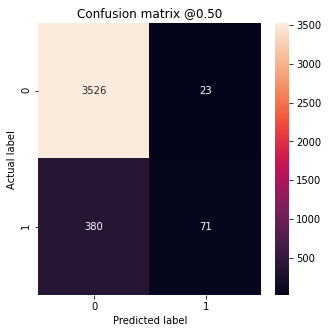

In [ ]:
# Plotting Metrics
baseline_results = model.evaluate(np.array(test_features.astype('float32')), np.array(test_labels.astype('float32')),
                                  batch_size=4, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()
plot_cm(np.array(test_labels.astype('float32')), test_predictions_baseline)